# **DC-GAN** (**D**eep **C**onvolutional **G**enerative **A**dversarial **N**etwork)

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import glob
from PIL import Image

from keras.datasets import mnist
from keras import layers
# from keras import losses
from keras import optimizers
from keras import models

print("TF version:", tf.__version__)
print(tf.config.list_physical_devices('GPU'))

TF version: 2.18.0
[]


## **1. Load and prepare the dataset**

You will use the MNIST dataset to train the generator and the discriminator. The generator will generate handwritten digits resembling the MNIST data.

In [ ]:
(train_images, train_labels), (_, _) = mnist.load_data()

train_images: np.ndarray = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images) / 255  # Normalize the images to [0, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 250
noise_dim = 100 # 100

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## **2. Create the models**

### The Generator


In [3]:
def make_generator_model(noise_dim: int) -> models.Sequential:
    model = models.Sequential(name="WGANGP_Generator_Model")
    
    # Reshape the input noise vector into a 4D tensor
    model.add(layers.Reshape((1, 1, noise_dim), input_shape=(noise_dim,)))
    
    # First Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Second Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=(2, 2), padding='valid'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Third Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    
    # Final Conv2DTranspose layer to produce the output image
    model.add(layers.Conv2DTranspose(1, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='sigmoid'))
    
    return model

generator = make_generator_model(noise_dim)
generator.summary()

C:\Users\br0445\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "WGANGP_Generator_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape (Reshape)               │ (None, 1, 1, 100)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 3, 3, 256)      │       230,656 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 7, 7, 128)      │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 1)      │           577 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 601,857 (2.30 MB)

 Trainable params: 600,961 (2.29 MB)

 Non-trainable params: 896 (3.50 KB)

Use the (as yet untrained) generator to create an image.

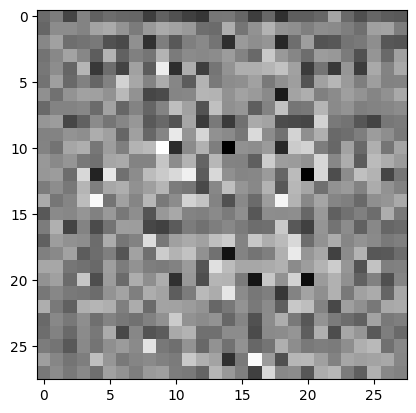

In [4]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)

# normaliza los valores de la imagen antes de mostrarla
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.show()

### The Discriminator

In [5]:
def make_discriminator_model() -> models.Sequential:
    model = models.Sequential(name="WGANGP_Discriminator_Model")
    
    # First Conv2D layer
    model.add(layers.Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25))
    
    # Second Conv2D layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25))
    
    # Third Conv2D layer
    model.add(layers.Conv2D(32, kernel_size=(3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1)) # no sigmoid
    
    return model

discriminator = make_discriminator_model()
discriminator.summary()

C:\Users\br0445\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "WGANGP_Discriminator_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 4, 4, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,881 (58.13 KB)

 Trainable params: 14,721 (57.50 KB)

 Non-trainable params: 160 (640.00 B)

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [6]:
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[-0.00665749]], shape=(1, 1), dtype=float32)


### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [ ]:
generator_optimizer = optimizers.Adam(1e-4)
discriminator_optimizer = optimizers.Adam(1e-4)

checkpoint_dir = 'results_p2/WGAN_GP/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## **4. Define the training loop**


The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [8]:
def gradient_penalty(real_images: tf.Tensor, fake_images: tf.Tensor, discriminator: models.Sequential) -> float:
    """Calcula el Gradient Penalty en WGAN-GP."""

    alpha = tf.random.uniform([BATCH_SIZE, 1, 1, 1], 0.0, 1.0)  # Interpolación
    interpolated = real_images + alpha * (fake_images - real_images)
    
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)  # Salida del discriminador

    grads = gp_tape.gradient(pred, [interpolated])[0]  # Gradientes respecto a imágenes interpoladas
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))  # Norma L2
    gp = tf.reduce_mean((norm - 1.0) ** 2)  # Penalización de gradiente
    return gp

def discriminator_loss(real_logits: tf.Tensor, fake_logits: tf.Tensor, gp, gp_weight=10) -> float:
    """Cálculo de la pérdida del discriminador con Gradient Penalty."""
    d_loss = tf.reduce_mean(fake_logits) - tf.reduce_mean(real_logits)  # Wasserstein Loss
    d_loss += gp_weight * gp  # Se añade la penalización de gradiente
    return d_loss

def generator_loss(fake_logits: tf.Tensor) -> float:
    """Cálculo de la pérdida del generador en WGAN-GP."""
    return -tf.reduce_mean(fake_logits)  # Maximiza la puntuación del generador

-------

In [9]:
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function
def train_step(real_images: tf.Tensor, gp_weight: int) -> None:
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = generator(noise, training=True)
        real_logits = discriminator(real_images, training=True)
        fake_logits = discriminator(fake_images, training=True)

        gen_loss = generator_loss(fake_logits)  # Pérdida del generador
        
        gp = gradient_penalty(real_images, fake_images, discriminator)  # Calcular GP
        disc_loss = discriminator_loss(real_logits, fake_logits, gp, gp_weight)  # Pérdida del discriminador

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

**Generate and save images**

In [10]:
def generate_and_save_images(model: models.Sequential, epoch: int, test_input: np.ndarray, show_figure: bool, last_figure: bool) -> None:
    # Notice 'training' is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions: np.ndarray = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 255, cmap="gray")
        plt.axis("off")

    if not last_figure:
        plt.savefig(f"results_p2/WGANGP/WGANGP_epoch_{epoch:03d}.png") 
    else:
        plt.savefig(f"results_p2/WGANGP_{epoch}_results.png")
    if show_figure:
        plt.show()
    plt.close()

In [11]:
def train(dataset: tf.data.Dataset, epochs: int, trace: int, gp_weight: int) -> None:
    gen_loss_history = []
    disc_loss_history = []
    for epoch in range(epochs):
        start = time.time()
        gen_episode_loss = 0
        disc_episode_loss = 0

        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch, gp_weight)
            gen_episode_loss += gen_loss
            disc_episode_loss += disc_loss

        generate_and_save_images(model=generator, epoch=epoch, test_input=seed, show_figure=False, last_figure=False)

        if epoch % trace == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f'Epoch {epoch}: {time.time()-start:.2f} secs, gen loss: {gen_episode_loss / BATCH_SIZE}, disc loss: {disc_episode_loss / BATCH_SIZE}')

        gen_loss_history.append(gen_episode_loss / BATCH_SIZE)
        disc_loss_history.append(disc_episode_loss / BATCH_SIZE)

    generate_and_save_images(model=generator, epoch=epochs, test_input=seed, show_figure=True, last_figure=True)

    return gen_loss_history, disc_loss_history

## **5. Train the model**
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

Epoch 0: 34.52 secs, gen loss: -5.140741348266602, disc loss: 93.61833190917969
Epoch 5: 29.54 secs, gen loss: -2.3133604526519775, disc loss: 1.9510011672973633
Epoch 10: 30.38 secs, gen loss: -1.1532405614852905, disc loss: 0.6269142627716064
Epoch 15: 30.69 secs, gen loss: -0.559194028377533, disc loss: 0.33747047185897827
Epoch 20: 30.59 secs, gen loss: 0.2017907202243805, disc loss: 0.05042714625597
Epoch 25: 30.66 secs, gen loss: 0.2069145292043686, disc loss: -0.03657377511262894
Epoch 30: 30.77 secs, gen loss: -0.31570351123809814, disc loss: -0.023019112646579742
Epoch 35: 30.91 secs, gen loss: -0.07172086834907532, disc loss: -0.18085920810699463
Epoch 40: 30.87 secs, gen loss: -0.1146896481513977, disc loss: -0.13979558646678925
Epoch 45: 31.14 secs, gen loss: -0.026303449645638466, disc loss: -0.09120677411556244
Epoch 50: 31.03 secs, gen loss: -0.19284453988075256, disc loss: -0.12335028499364853
Epoch 55: 31.32 secs, gen loss: 0.018843887373805046, disc loss: -0.145054221

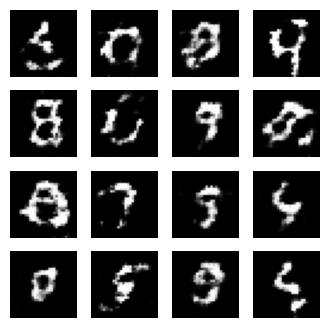

******* Total training time: 38 mins y 15.09 secs *******


In [12]:
EPOCHS = 75
trace = 5
gp_weight = 10

total_start = time.time()
gen_loss_history, disc_loss_history = train(train_dataset, EPOCHS, trace, gp_weight)
minutos, segundos = divmod(time.time()-total_start, 60)
print(f"******* Total training time: {int(minutos)} mins y {segundos:.2f} secs *******")

## **GAN losses history**

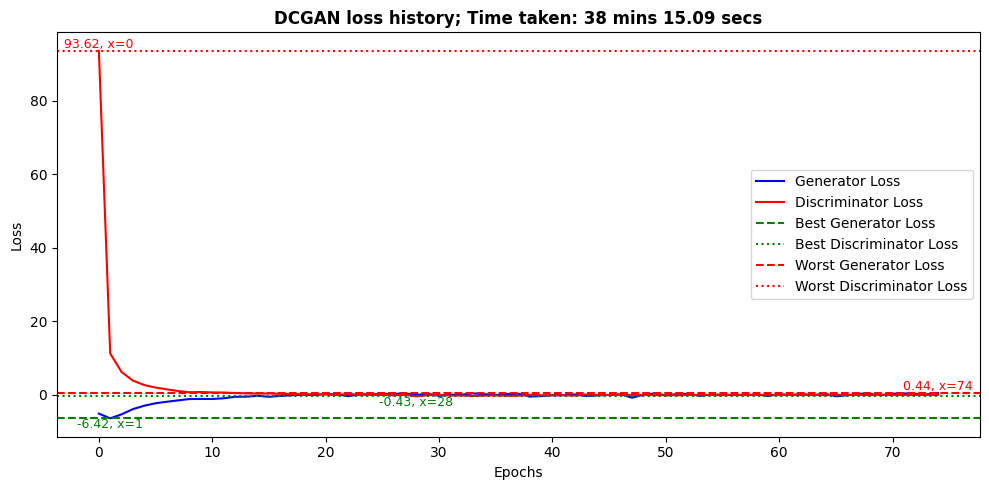

In [23]:
def plot_loss(gen_loss: list, disc_loss: list) -> None:
    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss, label="Generator Loss", color="blue")
    plt.plot(disc_loss, label="Discriminator Loss", color="red")
    
    max_gen_loss = max(gen_loss)
    max_disc_loss = max(disc_loss)
    min_gen_loss = min(gen_loss)
    min_disc_loss = min(disc_loss)
    plt.axhline(y=min_gen_loss, color='green', linestyle='--', label='Best Generator Loss')
    plt.axhline(y=min_disc_loss, color='green', linestyle=':', label='Best Discriminator Loss')
    plt.axhline(y=max_gen_loss, color='red', linestyle='--', label='Worst Generator Loss')
    plt.axhline(y=max_disc_loss, color='red', linestyle=':', label='Worst Discriminator Loss')

    best_gen_idx = gen_loss.index(min_gen_loss)
    best_disc_idx = disc_loss.index(min_disc_loss)
    worst_gen_idx = gen_loss.index(max_gen_loss)
    worst_disc_idx = disc_loss.index(max_disc_loss)
    plt.text(best_gen_idx, min_gen_loss, f'{min_gen_loss:.2f}, x={best_gen_idx}', color='green', fontsize=9, ha='center', va='top')
    plt.text(best_disc_idx, min_disc_loss, f'{min_disc_loss:.2f}, x={best_disc_idx}', color='green', fontsize=9, ha='center', va='top')
    plt.text(worst_gen_idx, max_gen_loss, f'{max_gen_loss:.2f}, x={worst_gen_idx}', color='red', fontsize=9, ha='center', va='bottom')
    plt.text(worst_disc_idx, max_disc_loss, f'{max_disc_loss:.2f}, x={worst_disc_idx}', color='red', fontsize=9, ha='center', va='bottom')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"DCGAN loss history; Time taken: {int(minutos)} mins {segundos:.2f} secs", fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"results_p2/WGANGP_{EPOCHS}_loss_history.png")
    plt.show()

plot_loss(gen_loss_history, disc_loss_history)

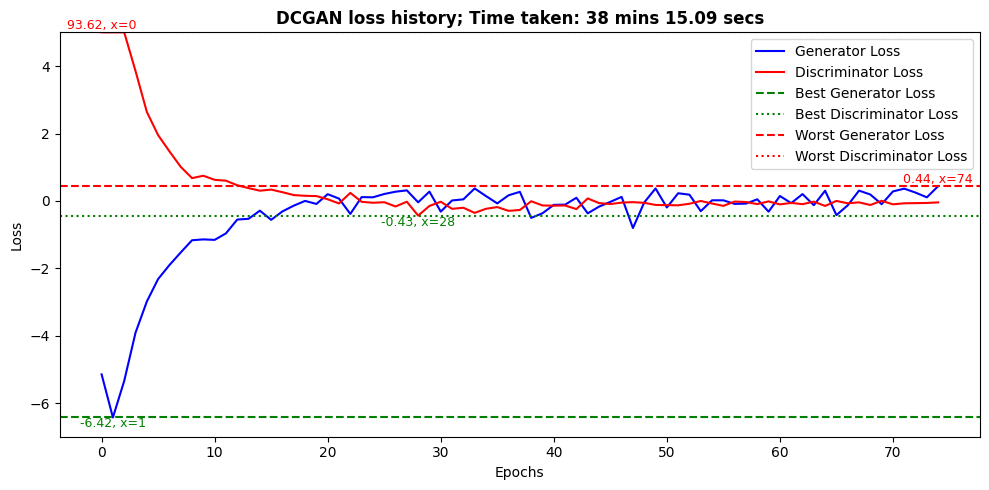

In [27]:
import numpy as np

def plot_loss(gen_loss: list, disc_loss: list, y_max: float = 5.0) -> None:
    # Truncar los valores al umbral
    gen_loss_truncated = np.minimum(gen_loss, y_max)
    disc_loss_truncated = np.minimum(disc_loss, y_max)

    plt.figure(figsize=(10, 5))
    plt.plot(gen_loss_truncated, label="Generator Loss", color="blue")
    plt.plot(disc_loss_truncated, label="Discriminator Loss", color="red")
    
    max_gen_loss = min(max(gen_loss), y_max)
    max_disc_loss = min(max(disc_loss), y_max)
    min_gen_loss = min(gen_loss)
    min_disc_loss = min(disc_loss)
    plt.axhline(y=min_gen_loss, color='green', linestyle='--', label='Best Generator Loss')
    plt.axhline(y=min_disc_loss, color='green', linestyle=':', label='Best Discriminator Loss')
    plt.axhline(y=max_gen_loss, color='red', linestyle='--', label='Worst Generator Loss')
    plt.axhline(y=max_disc_loss, color='red', linestyle=':', label='Worst Discriminator Loss')

    best_gen_idx = gen_loss.index(min_gen_loss)
    best_disc_idx = disc_loss.index(min_disc_loss)
    worst_gen_idx = gen_loss.index(max(gen_loss))
    worst_disc_idx = disc_loss.index(max(disc_loss))
    plt.text(best_gen_idx, min_gen_loss, f'{min_gen_loss:.2f}, x={best_gen_idx}', color='green', fontsize=9, ha='center', va='top')
    plt.text(best_disc_idx, min_disc_loss, f'{min_disc_loss:.2f}, x={best_disc_idx}', color='green', fontsize=9, ha='center', va='top')
    plt.text(worst_gen_idx, max_gen_loss, f'{max(gen_loss):.2f}, x={worst_gen_idx}', color='red', fontsize=9, ha='center', va='bottom')
    plt.text(worst_disc_idx, max_disc_loss, f'{max(disc_loss):.2f}, x={worst_disc_idx}', color='red', fontsize=9, ha='center', va='bottom')

    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"DCGAN loss history; Time taken: {int(minutos)} mins {segundos:.2f} secs", fontweight='bold')
    plt.tight_layout()
    
    # Establecer el límite superior del eje Y
    plt.ylim(top=y_max)
    
    plt.savefig(f"results_p2/WGANGP_{EPOCHS}_loss_history.png")
    plt.show()

# Ejemplo de uso:
plot_loss(gen_loss_history, disc_loss_history, y_max=5.0)


**Restore the latest checkpoint.**

In [14]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **6. Create a GIF**

In [15]:
def create_gif_from_folder(folder_path: str, output_filename: str, duration: int) -> None:
    image_files = sorted(glob.glob(os.path.join(folder_path, "*.png")))
    frames = [Image.open(file) for file in image_files]
    frames[0].save(
        output_filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=1
    )

create_gif_from_folder(folder_path="results_p2/WGANGP", output_filename=f"results_p2/WGANGP_{EPOCHS}_results.gif", duration=30)

**Remove all folder images**

In [ ]:
def remove_all_images(folder: str, extension: str = 'png') -> None:
    image_files = glob.glob(os.path.join(folder, f'*.{extension}'))
    for image_file in image_files:
        os.remove(image_file)
    print(f"Removed {len(image_files)} {extension} images from {folder}")

remove_all_images('results_p2/WGANGP/epochs')